<a href="https://colab.research.google.com/github/unguyen14/recommendation_system/blob/main/Movie_recommendation_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System
## Authors: Fabio Turazzi and Winnie Nguyen

This notebook demonstrates a recommendation system combining the ratings dataset [MovieLens 25M dataset](https://grouplens.org/datasets/movielens/25m/) and movie metadata from [The Movie Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) on Kaggle. The two datasets were joined using movie Ids from IMDb.
In order to provide different perspectives on recommendation systems, we examine multiple approaches to generate a lists of movies based on their genres, contents, as well as ratings by users.

## Datasets Used
We use 4 datasets:
- links.csv: containing movieId, imdbId, tmdbId
- movies.csv: containing movieId, title, genres
- ratings.csv: containing userId, movieId, rating, timestamp
- movies_metadata.csv: containing imdb_id, overview


## Notebook Structure:
In this notebook, we will follow the following process in order to build our robusted recommendation engine:
- 1. **Dataset Loading and Preparation**: loading necessary libraries, importing datasets, joining datasets

- 2. **Simple Recommendation System**: generally analyzing most popular and highest rated movies across genres.

- 3. **Content-Based Recommendataion**: using contents as the basis to suggest similar movies.
    - 3.1. *Genre similarity*: recommendations based on the similarities between movie genres.
    - 3.2. *Description similarity*: based on text similarities in movie descriptions.
    
- 4. **Collaborative Filtering**: using ratings as the basis to suggest similar movies.
    - 4.1. *Item-based filtering*: provides recommendations given a movie title by analyzing other items similarly rated by users.
    - 4.2. *User-based filtering*: focuses on a target user to provide suggestions, by analyzing favorite movies by other similar users. Includes a model for rating prediction for a given user and movie.
    
## Methodologies:
We apply multiple statistical, Machine Learning, and Natural Language Processing methods to solve the different prioritization problems. The used methodologies used include:
* Jaccard similarity coefficient
* Cosine similarity
* TF-IDF
* KNNRegressor


## References:
- Datacamp Recommendation System materials
- [Scikit-learn documentation](https://scikit-learn.org/0.21/documentation.html)

# 1. Dataset Loading and Preparation

### Loading necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Import datasets

In [ ]:
#read files
df_links = pd.read_csv('data/links.csv', low_memory=False)
df_movies = pd.read_csv('data/movies.csv', low_memory=False)
df_ratings = pd.read_csv('data/ratings.csv', low_memory=False)
df_metadata = pd.read_csv('data/movies_metadata.csv', low_memory=False)

### Dataset Overview

In [ ]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Keeping just the description column for our content based filtering
df_descriptions = df_metadata[['imdb_id', 'overview']].copy()
df_descriptions.head()

,imdb_id,overview
0,tt0114709,"Led by Woody, Andy's toys live happily in his ..."
1,tt0113497,When siblings Judy and Peter discover an encha...
2,tt0113228,A family wedding reignites the ancient feud be...
3,tt0114885,"Cheated on, mistreated and stepped on, the wom..."
4,tt0113041,Just when George Banks has recovered from his ...


In [ ]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### Joining Movie Descriptions

In [ ]:
#Formatting imdb_id to join dataframes
df_descriptions.imdb_id = df_descriptions.imdb_id.apply(lambda x: str(x).replace("tt", ""))
df_descriptions.imdb_id = pd.to_numeric(df_descriptions.imdb_id, errors="coerce")
df_descriptions.dropna(inplace=True)

#Merging dataframes using the "links" dataset
df_descriptions = pd.merge(df_links, df_descriptions, left_on=['imdbId'], right_on=['imdb_id'], how='inner')
df_descriptions = df_descriptions.drop(columns=['imdb_id', 'tmdbId'], axis=1)
df_descriptions = pd.merge(df_descriptions, df_movies, how='inner')
df_descriptions = df_descriptions.drop(columns=['imdbId'], axis=1)
df_descriptions
# #Replace NaN with an empty string
df_descriptions['overview'] = df_descriptions['overview'].fillna('')

df_descriptions.head()

,movieId,overview,title,genres
0,1,"Led by Woody, Andy's toys live happily in his ...",Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,When siblings Judy and Peter discover an encha...,Jumanji (1995),Adventure|Children|Fantasy
2,3,A family wedding reignites the ancient feud be...,Grumpier Old Men (1995),Comedy|Romance
3,4,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Just when George Banks has recovered from his ...,Father of the Bride Part II (1995),Comedy


# 2. Simple Recommendation System
- Our simple recommendation system represents the general suggestion on main pages, considering overall most popular and well rated items to be displayed. 
- For this purpose, we will use the IMDB's top movie calculation formula to calculate weighted rating (WR) for each movie:

<div align="center">$\Large WR = (v ÷ (v+m)) \times R + (m ÷ (v+m)) \times C$</div>
    
Where:

    R = average for the movie (mean) = (Rating)
    v = number of votes for the movie = (votes)
    m = minimum votes required to be listed in the Top Movies list
    C = the mean vote across the whole report

### Grouping ratings by movie

In [ ]:
#Grouping rating by movie
movie_avg_rating = df_ratings.groupby(["movieId"], as_index=False).agg(avg_rating = ("rating", "mean"),
                                                 rating_count = ("movieId", 'count')).reset_index(drop=True)
movie_avg_rating.head()

,movieId,avg_rating,rating_count
0,1,3.893708,57309
1,2,3.251527,24228
2,3,3.142028,11804
3,4,2.853547,2523
4,5,3.058434,11714


In [ ]:
#merging rating with movies' names
movie_avg_rating = pd.merge(movie_avg_rating,
                 df_movies,
                 on='movieId')

movie_avg_rating.head()

,movieId,avg_rating,rating_count,title,genres
0,1,3.893708,57309,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,3.251527,24228,Jumanji (1995),Adventure|Children|Fantasy
2,3,3.142028,11804,Grumpier Old Men (1995),Comedy|Romance
3,4,2.853547,2523,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3.058434,11714,Father of the Bride Part II (1995),Comedy


### Checking the 95th percentile to decide rating threshold
- To determine a threshold for popular movies, we choose the ones with top 5% amount of rating from users, by calculating the 95 quantile. 

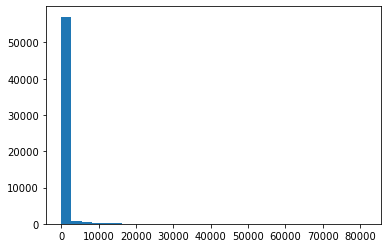

In [ ]:
#Generate histogram
plt.hist(x=movie_avg_rating.rating_count, bins=30)
plt.show()

In [ ]:
#Calculate rating count threshold
count_thresh = movie_avg_rating.rating_count.quantile(0.95).astype(int)
print(count_thresh)

1503


### Comments:
- For this first simple recommendation system, we will consider the movies with more than 1503 ratings.

In [ ]:
#Filtering the movies below the threshold
movie_avg_rating = movie_avg_rating[movie_avg_rating.rating_count > count_thresh]
movie_avg_rating.head()

,movieId,avg_rating,rating_count,title,genres
0,1,3.893708,57309,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,3.251527,24228,Jumanji (1995),Adventure|Children|Fantasy
2,3,3.142028,11804,Grumpier Old Men (1995),Comedy|Romance
3,4,2.853547,2523,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3.058434,11714,Father of the Bride Part II (1995),Comedy


In [ ]:
#Storing the total rating average for calculation
total_rating_avg = df_ratings.rating.mean()
print("Total rating average:", total_rating_avg)

Total rating average: 3.533854451353085


### Creating Recommendations
- Using the formula from IMDB, we will calculate and add to the dataframe the weighted rating for each movie. 
- The recommendations will then be generated by highlighting the items with highest weighted rating value, with the option to use genres as a filter.

In [ ]:
#Calculating the weighted average of ratings
movie_avg_rating['weighted_avg'] = (movie_avg_rating.rating_count / (movie_avg_rating.rating_count + count_thresh)) * movie_avg_rating.avg_rating \
                                        + (count_thresh / (count_thresh + movie_avg_rating.rating_count)) * total_rating_avg
#Sorting the dataframe
movie_avg_rating = movie_avg_rating.sort_values(by=['weighted_avg'], ascending=False).reset_index(drop=True)
#Deleting unnecessary columns
movie_avg_rating = movie_avg_rating.drop(columns=['rating_count', 'movieId', 'avg_rating'], axis=1)
#Renaming the rating column
movie_avg_rating.rename(columns={"weighted_avg": "rating"}, inplace=True)

movie_avg_rating.head()

,title,genres,rating
0,"Shawshank Redemption, The (1994)",Crime|Drama,4.397643
1,"Godfather, The (1972)",Crime|Drama,4.302335
2,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.264518
3,"Godfather: Part II, The (1974)",Crime|Drama,4.231105
4,Schindler's List (1993),Drama|War,4.230253


In [ ]:
#Declaring the function that will be used to generate a list of popular movies, accepting genre and number of movies as arguments
def get_recommendation(genre = "All", num_recommendations = 10):
    if genre == "All":
        results = movie_avg_rating.head(num_recommendations)
    else:
        results = movie_avg_rating[movie_avg_rating['genres'].str.contains(genre)].head(num_recommendations)
        results = results.reset_index(drop=True)
    return results

### Getting Top Movies Overall
- Using the function written above, we will generate a list of top 20 most popular and highest rated movies in the list

In [ ]:
recommendations = get_recommendation(num_recommendations=20)
recommendations

,title,genres,rating
0,"Shawshank Redemption, The (1994)",Crime|Drama,4.397643
1,"Godfather, The (1972)",Crime|Drama,4.302335
2,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.264518
3,"Godfather: Part II, The (1974)",Crime|Drama,4.231105
4,Schindler's List (1993),Drama|War,4.230253
5,Fight Club (1999),Action|Crime|Drama|Thriller,4.210994
6,One Flew Over the Cuckoo's Nest (1975),Drama,4.191259
7,Rear Window (1954),Mystery|Thriller,4.189101
8,12 Angry Men (1957),Drama,4.184035
9,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama,4.181902


### Getting Top 10 Movies by Genre
- Using the same function, we can filter out movies specifying a genre. 
- The 2 examples below will get the top Comedy and Action movies respectively.

In [ ]:
recommendations = get_recommendation("Comedy")
recommendations

,title,genres,rating
0,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.179480
1,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.176783
2,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,4.124137
3,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,4.117739
4,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.106371
5,Fargo (1996),Comedy|Crime|Drama|Thriller,4.093822
6,"Sting, The (1973)",Comedy|Crime,4.089119
7,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance,4.077475
8,Wallace & Gromit: The Wrong Trousers (1993),Animation|Children|Comedy|Crime,4.071835
9,Intouchables (2011),Comedy|Drama,4.062422


In [ ]:
recommendations = get_recommendation("Action")
recommendations

,title,genres,rating
0,Fight Club (1999),Action|Crime|Drama|Thriller,4.210994
1,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama,4.181902
2,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.144435
3,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,4.142341
4,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.141532
5,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.136088
6,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,4.132380
7,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.128540
8,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.108136
9,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.107639


# 3. Content-Based Filtering
- In content-based filtering, we will consider movies' *genres and short overviews* to generate lists of similar movies. 
- Due to computational expense and runtime, we applied this model considering a sample of 5000 most popular movies.
- In Section 3.1, we use jaccard similarity to compare genre overlapping between movies and determine most relevant movies.
- In Section 3.2, we will analyze movie descriptions using NLP to identify items with similar contents.

## 3.1 Content-Based - Genres Similarity

- Jaccard index, or Jaccard similarity coefficient, measures the similarity between sample sets A and B, using the formula:

<div align="center">$\Large J(A,B) = \frac{|A \bigcap B|}{|A \bigcup B|}$  with  $\Large 0 \leq J(A,B)  \leq 1$</div>

- Using this Jaccard coefficient, we will determine movies with a high correlation of overlapping genres with any given target movie, outputting a list of recommendations. 

In [ ]:
# Sample top 5000 movies to be analyzed
df_movies_genres = get_recommendation("All",5000).copy()
df_movies_genres.drop(columns=['rating'], inplace=True)

In [ ]:
# Split genre strings into lists
df_movies_genres.genres = df_movies_genres.genres.apply(lambda x: x.split('|'))
df_movies_genres.head()

,title,genres
0,"Shawshank Redemption, The (1994)","[Crime, Drama]"
1,"Godfather, The (1972)","[Crime, Drama]"
2,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]"
3,"Godfather: Part II, The (1974)","[Crime, Drama]"
4,Schindler's List (1993),"[Drama, War]"


In [ ]:
#Exploding genres to individual rows
df_movies_genres = df_movies_genres.explode('genres').reset_index(drop=True)
# Delete row indexes with no genres
df_movies_genres.drop(df_movies_genres[ df_movies_genres['genres'] == "(no genres listed)" ].index , inplace=True)

df_movies_genres.head()

,title,genres
0,"Shawshank Redemption, The (1994)",Crime
1,"Shawshank Redemption, The (1994)",Drama
2,"Godfather, The (1972)",Crime
3,"Godfather, The (1972)",Drama
4,"Usual Suspects, The (1995)",Crime


In [ ]:
# Create cross-tabulated DataFrame from name and genre_list columns
movie_cross_table = pd.crosstab(df_movies_genres['title'], df_movies_genres['genres'])
movie_cross_table.head()

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
(500) Days of Summer (2009),0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
*batteries not included (1987),0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
10 Cloverfield Lane (2016),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10 Things I Hate About You (1999),0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Calculate all pairwise distances
jaccard_distances = pdist(movie_cross_table.values, metric='jaccard')

# Convert the distances to a square matrix
jaccard_similarity_array = 1 - squareform(jaccard_distances)

# Wrap the array in a pandas DataFrame
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, index=movie_cross_table.index, columns=movie_cross_table.index)

jaccard_similarity_df.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),12 Angry Men (1957),...,Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),[REC] (2007),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",1.000000,0.333333,0.250000,0.0,0.500000,0.000000,0.333333,0.000000,0.500000,0.000000,...,0.000000,0.333333,0.000000,0.333333,1.000000,0.200000,0.000000,0.000000,0.000000,0.500000
(500) Days of Summer (2009),0.333333,1.000000,0.166667,0.0,0.666667,0.200000,0.200000,0.000000,0.250000,0.333333,...,0.200000,0.200000,0.200000,0.200000,0.333333,0.142857,0.200000,0.000000,0.000000,0.250000
*batteries not included (1987),0.250000,0.166667,1.000000,0.0,0.200000,0.000000,0.400000,0.166667,0.500000,0.000000,...,0.000000,0.166667,0.000000,0.166667,0.250000,0.285714,0.000000,0.166667,0.000000,0.200000
10 Cloverfield Lane (2016),0.000000,0.000000,0.000000,1.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000
10 Things I Hate About You (1999),0.500000,0.666667,0.200000,0.0,1.000000,0.250000,0.250000,0.000000,0.333333,0.000000,...,0.000000,0.250000,0.000000,0.250000,0.500000,0.166667,0.000000,0.000000,0.000000,0.333333


### Creating Recommendations

In [ ]:
#Funtion to find similar movies based on genres, accepting a target movie and the desired size of returned list
def find_similar_genres(movie_name, num_recommendations = 10):
    #locate the row with specified movie and the similarity coefficient
    jaccard_similarity_series = jaccard_similarity_df.loc[movie_name]
    #sort value
    ordered_similarities = jaccard_similarity_series.drop([movie_name]).sort_values(ascending=False)
    # Returns the results
    return ordered_similarities.head(num_recommendations)

In [ ]:
find_similar_genres("Star Wars: Episode V - The Empire Strikes Back (1980)")

title
Sky Captain and the World of Tomorrow (2004)           1.0
Demolition Man (1993)                                  1.0
Black Panther (2017)                                   1.0
Star Trek Beyond (2016)                                1.0
Star Trek III: The Search for Spock (1984)             1.0
Star Wars: Episode I - The Phantom Menace (1999)       1.0
Star Wars: Episode III - Revenge of the Sith (2005)    1.0
Star Wars: Episode IV - A New Hope (1977)              1.0
Star Wars: Episode VI - Return of the Jedi (1983)      1.0
Stargate (1994)                                        1.0
Name: Star Wars: Episode V - The Empire Strikes Back (1980), dtype: float64

## 3.2 Content-based: Description similarities
- In order to compare the movies' descriptions, we will use TF-IDF to determine keywords' importance in all desciptions, and then compare the result between movies using Cosine similarity. 

### TF-IDF
-  **TF-IDF (Term frequency inverse document frequency)** can determine keywords' importance based on their frequencies in the corpus, calculated using the following formula:

<div align="center">$\Large tfidf(t,D) = tf(t,d) \times idf(t,D)$</div>

    with:

$\Large tf(t,D) = 0.5 + 0.5 \times \frac{f_{t,d}}{max\{f_{t',d} : t'\in d\}}$

$\Large idf(t,D) = log \frac{N}{|\{d \in D : t \in d\}|}$

- For more information on tf-idf, please visit [TF-IDF Website](http://www.tfidf.com/)

### Cosine similarity
- Cosine similarity measures the distance between 2 non-zero vectors, equating to the cosine of angle between them. Using this calculation, we can identify similar movie descriptions by cross-referencing word occurances.

In [ ]:
# Sample top 5000 movies to be analyzed
df_desc_recomm = get_recommendation("All",5000).copy()
df_desc_recomm = pd.merge(df_desc_recomm, df_descriptions, on='title')
df_desc_recomm.drop(columns=['genres_x', 'genres_y', 'rating', 'movieId'], inplace=True)

df_desc_recomm.head()

,title,overview
0,"Shawshank Redemption, The (1994)",Framed in the 1940s for the double murder of h...
1,"Godfather, The (1972)","Spanning the years 1945 to 1955, a chronicle o..."
2,"Usual Suspects, The (1995)","Held in an L.A. interrogation room, Verbal Kin..."
3,"Godfather: Part II, The (1974)",In the continuing saga of the Corleone crime f...
4,Schindler's List (1993),The true story of how businessman Oskar Schind...


In [ ]:
# get words with at least 2 mentions or which appear in less than 75% of movies, then filter stop words
tfidf = TfidfVectorizer(min_df=2, max_df=0.75, stop_words='english')

In [ ]:
# fit the description data to tfidf
vertorized_data = tfidf.fit_transform(df_desc_recomm.overview)
# print(tfidf.get_feature_names())

In [ ]:
# Add words to a dataframe containing the movie title
df_tfidf = pd.DataFrame(vertorized_data.toarray(),
                        columns=tfidf.get_feature_names())

df_tfidf.index = df_desc_recomm['title']
df_tfidf.head(3)

,00,000,007,10,100,10th,11,12,13,14,...,zeus,zion,zoe,zombie,zombies,zone,zones,zoo,zooey,zorro
title,,,,,,,,,,,,,,,,,,,,,
"Shawshank Redemption, The (1994)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Godfather, The (1972)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Usual Suspects, The (1995)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Filter numeric columns not corresponding to year

In [ ]:
#Find numeric columns
int_columns = [s for s in df_tfidf.columns if s.isdigit()]
#Filter columns that start with 1 or 2 and have 4 characters (likely years)
int_columns = list(filter(lambda x: (not x.startswith('1') and not x.startswith('2')) or len(x) != 4, int_columns))

#Dropping the int columns
df_tfidf.drop(columns=int_columns, inplace=True)
df_tfidf.head(3)

,10th,15th,16th,17th,1800,1863,1890s,18th,1900s,1910,...,zeus,zion,zoe,zombie,zombies,zone,zones,zoo,zooey,zorro
title,,,,,,,,,,,,,,,,,,,,,
"Shawshank Redemption, The (1994)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Godfather, The (1972)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Usual Suspects, The (1995)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Identify similarity between data with Cosine Similarity

In [ ]:
# calculate similarity between all items
cosine_sim = cosine_similarity(df_tfidf)

In [ ]:
# pur results in a dataframe
df_similarity = pd.DataFrame(cosine_sim, columns=df_tfidf.index, index=df_tfidf.index)
df_similarity.head()

title,"Shawshank Redemption, The (1994)","Godfather, The (1972)","Usual Suspects, The (1995)","Godfather: Part II, The (1974)",Schindler's List (1993),Fight Club (1999),One Flew Over the Cuckoo's Nest (1975),Rear Window (1954),12 Angry Men (1957),Seven Samurai (Shichinin no samurai) (1954),...,Showgirls (1995),Wild Wild West (1999),Grease 2 (1982),Spice World (1997),Home Alone 3 (1997),Super Mario Bros. (1993),Anaconda (1997),Batman & Robin (1997),Speed 2: Cruise Control (1997),Battlefield Earth (2000)
title,,,,,,,,,,,,,,,,,,,,,
"Shawshank Redemption, The (1994)",1.000000,0.006940,0.000000,0.008126,0.000000,0.008379,0.0,0.034679,0.017646,0.0,...,0.026994,0.000000,0.021276,0.008312,0.0,0.033757,0.000000,0.007657,0.011338,0.000000
"Godfather, The (1972)",0.006940,1.000000,0.069111,0.424837,0.000000,0.000000,0.0,0.000000,0.014397,0.0,...,0.000000,0.000000,0.030850,0.046529,0.0,0.000000,0.000000,0.034888,0.000000,0.000000
"Usual Suspects, The (1995)",0.000000,0.069111,1.000000,0.059527,0.015213,0.000000,0.0,0.000000,0.030280,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.035370,0.000000,0.000000
"Godfather: Part II, The (1974)",0.008126,0.424837,0.059527,1.000000,0.000000,0.008079,0.0,0.021443,0.009771,0.0,...,0.132776,0.000000,0.043473,0.000000,0.0,0.000000,0.000000,0.026333,0.023739,0.000000
Schindler's List (1993),0.000000,0.000000,0.015213,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.018385,0.000000,0.000000,0.0,0.000000,0.019657,0.000000,0.000000,0.075014


### Creating Recommendations

In [ ]:
#Function to find the most similar movide based on the description
def find_similar_des(movie_name, num_recommendations=10):
    cosine_sim_series = df_similarity.loc[movie_name]
    #sort the dataframe
    sorted_result = cosine_sim_series.drop([movie_name]).sort_values(ascending=False)
    
    return sorted_result.head(num_recommendations)

In [ ]:
find_similar_des("Star Wars: Episode V - The Empire Strikes Back (1980)")

title
Star Wars: Episode IV - A New Hope (1977)              0.451199
Star Wars: Episode VI - Return of the Jedi (1983)      0.349217
Star Wars: Episode VII - The Force Awakens (2015)      0.266170
Star Wars: Episode III - Revenge of the Sith (2005)    0.226523
Cool Hand Luke (1967)                                  0.124833
Star Wars: Episode I - The Phantom Menace (1999)       0.122387
Star Wars: Episode II - Attack of the Clones (2002)    0.100162
Aladdin (1992)                                         0.097780
Sleeping Beauty (1959)                                 0.092597
Baraka (1992)                                          0.089945
Name: Star Wars: Episode V - The Empire Strikes Back (1980), dtype: float64

# 4. Collaborative filtering
- For the collaborative filtering system, we analyzed correlations between user ratings in order to identify similarities. We consider the following 2 approaches:
    - Item-based: generate recommendations for a target movie by identifying other similarly rated titles, done by applying cosine similarity.
        - Includes an improved item-based model, combining an input from our description-based recommender to generate more cohesive suggestions.  
    - User-based: generate recommendations for a target user by identifying well-rated movies by similar users and filtering out the recommendations already seen by the target user.
        - Includes a predictive model to estimate how a given user would rate a movie. 

## 4.1. Item-Based Collaborative Filtering
- Similarly to our content-based approach, we will focus on a sample of 5000 most popular movies across all genres. We performed this filter using our function written in the Simple Recommendation System section.
- Since the titles rated by each user varies, we have centered the ratings around 0 in order to provide better scaling for estimations. 
- We then applied cosine similarity analysis to obtain a table of movie relationships based on user ratings, which was then used to generate our recommendations.

In [ ]:
# Merge dataframes to bring movie names
df_ratings = pd.merge(df_ratings, df_movies, on='movieId')
#Drop unnecessary columns
df_ratings = df_ratings.drop(columns=['timestamp','movieId','genres'], axis=1)
#Drop duplicates to keep last rating given by user
df_ratings = df_ratings.drop_duplicates(subset=['userId', 'title'], keep='last')

# Filter most polular movies
df_pop_ratings = pd.merge(df_ratings, get_recommendation("All",5000).copy().drop(columns=['rating', 'genres']), on='title')
df_pop_ratings = df_pop_ratings.reset_index(drop=True)

df_pop_ratings.head()

,userId,rating,title
0,1,5.0,Pulp Fiction (1994)
1,3,5.0,Pulp Fiction (1994)
2,4,4.0,Pulp Fiction (1994)
3,5,4.0,Pulp Fiction (1994)
4,7,4.0,Pulp Fiction (1994)


In [ ]:
#Create pivot table of ratings
title_ratings_pivot = df_pop_ratings.pivot(index='userId', columns='title', values='rating')
title_ratings_pivot.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),12 Angry Men (1957),...,Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),[REC] (2007),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,4.0,3.5,NaN,NaN,NaN,3.5,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,4.5,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# recenter data around 0 and fill Nan  
# Get the average rating for each user 
avg_ratings = title_ratings_pivot.mean(axis=1)

# Center each users ratings around 0
title_ratings_table_centered = title_ratings_pivot.sub(avg_ratings, axis=0)

# Fill in the missing data with 0s
title_ratings_table_normed = title_ratings_table_centered.fillna(0)
title_ratings_table_normed.head()

In [ ]:
# transpose movie to index for item based
movie_based = title_ratings_table_normed.T
movie_based.head()

userId,1,2,3,4,5,6,7,8,9,10,...,162532,162533,162534,162535,162536,162537,162538,162539,162540,162541
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.917178
(500) Days of Summer (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
*batteries not included (1987),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10 Cloverfield Lane (2016),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.421569,...,0.0,-1.088983,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000


In [ ]:
# Calculate cosine similarities for our item-based dataframe
similarities = cosine_similarity(movie_based)
# Wrap the similarities in a DataFrame
df_movie_similarity = pd.DataFrame(similarities, index=movie_based.index, columns=movie_based.index)
df_movie_similarity.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),12 Angry Men (1957),...,Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),[REC] (2007),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",1.000000,-0.003306,0.040960,0.003214,0.007690,0.005386,0.027102,-0.020474,0.015117,-0.043731,...,-0.001074,-0.020870,-0.004836,-0.008369,0.014527,-0.004555,-0.003419,0.017637,0.012628,0.084297
(500) Days of Summer (2009),-0.003306,1.000000,-0.006602,0.018147,0.023853,-0.029539,-0.023602,-0.011066,-0.032766,0.017625,...,0.019949,0.004549,0.023080,0.041274,-0.010333,0.012507,0.015779,-0.005618,-0.030105,-0.010460
*batteries not included (1987),0.040960,-0.006602,1.000000,-0.001200,0.016142,0.022138,0.024278,0.009570,0.016061,-0.035216,...,-0.004734,-0.009043,-0.014289,-0.009894,0.001684,-0.003461,0.007467,0.001050,0.024019,0.006309
10 Cloverfield Lane (2016),0.003214,0.018147,-0.001200,1.000000,-0.008594,-0.028963,-0.022987,-0.012007,-0.032139,0.022239,...,0.026332,-0.003410,0.049127,0.042108,-0.011681,0.034286,0.049506,-0.005217,-0.050854,-0.002578
10 Things I Hate About You (1999),0.007690,0.023853,0.016142,-0.008594,1.000000,0.014515,0.020798,0.016509,-0.000475,-0.032232,...,-0.011749,0.006919,-0.015923,0.001618,0.004124,0.011097,-0.000867,-0.000620,0.032241,0.011114


### Creating Recommendations

In [ ]:
#function to find similar movies based on users' rating
def find_similar_rating(movie_name, num_recommendations = 10):
    cosine_similarity_series = df_movie_similarity.loc[movie_name]
    # Sort these values highest to lowest
    ordered_similarities = cosine_similarity_series.drop([movie_name]).sort_values(ascending=False)
    
    return ordered_similarities.head(num_recommendations)

In [ ]:
find_similar_rating('Star Wars: Episode V - The Empire Strikes Back (1980)')

title
Star Wars: Episode IV - A New Hope (1977)                                         0.658184
Star Wars: Episode VI - Return of the Jedi (1983)                                 0.592826
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    0.447282
Indiana Jones and the Last Crusade (1989)                                         0.335323
Matrix, The (1999)                                                                0.283854
Lord of the Rings: The Fellowship of the Ring, The (2001)                         0.269870
Aliens (1986)                                                                     0.263332
Alien (1979)                                                                      0.261108
Back to the Future (1985)                                                         0.254422
Blade Runner (1982)                                                               0.251197
Name: Star Wars: Episode V - The Empire Strikes Back (1980), dtype: float64

### Improved Item-Based Collaborative Filtering
- Since this analysis only takes into consideration the user ratings to generate recommendations, we found beneficial to improve it by combining the output from our description-based model.
- To combine the results, we averaged the scores provided by each of the two models to prioritize similarly rated movies that also contain similar plots/descriptions.

In [ ]:
def improved_item_based_recommend(movie_name, num_recommendations = 10):
    
    #Combine rating results from both models, take average and sort list
    combined_results = pd.merge(find_similar_des(movie_name, 1000), find_similar_rating(movie_name, 1000), 
                                   on='title').mean(axis=1).sort_values(ascending=False)
    return combined_results.head(num_recommendations)

In [ ]:
improved_item_based_recommend('Star Wars: Episode V - The Empire Strikes Back (1980)')

title
Star Wars: Episode IV - A New Hope (1977)                    0.554692
Star Wars: Episode VI - Return of the Jedi (1983)            0.471022
Star Wars: Episode VII - The Force Awakens (2015)            0.199830
Lord of the Rings: The Fellowship of the Ring, The (2001)    0.141694
Princess Bride, The (1987)                                   0.136866
Star Wars: Episode III - Revenge of the Sith (2005)          0.132364
Die Hard (1988)                                              0.125950
Terminator 2: Judgment Day (1991)                            0.120448
Godfather: Part II, The (1974)                               0.118786
Cool Hand Luke (1967)                                        0.116750
dtype: float64

## 4.2. User-Based Collaborative Filtering
- In order to build a personalized system for individual users, we analyzed correlations in user ratings' data to identify similar users and infer potential movies that a target user would like.
- To provide a more complete implementation, we also applied the Nearest Neighbors concept to provide a predictor of estimated ratings for the given user using a KNNRegressor. 
- Due to the limited processing resources, we will consider a sample of 1000 users which provided the highest number of ratings in the dataset.

In [ ]:
#Group ratings dataframe by user
df_top_users = df_ratings.groupby(["userId"], as_index=False).agg(num_ratings = ("rating", "count")).reset_index(drop=True)
#Define most active users
df_top_users = df_top_users.sort_values(by="num_ratings", ascending=False).head(1000)
# Filter most active users 
df_user_ratings = pd.merge(df_ratings, df_top_users.copy().drop(columns=['num_ratings']), on='userId')
df_user_ratings

,userId,rating,title
0,548,4.5,Pulp Fiction (1994)
1,548,4.0,Dirty Dancing (1987)
2,548,4.0,Gattaca (1997)
3,548,4.0,Back to the Future Part II (1989)
4,548,3.0,Back to the Future Part III (1990)
...,...,...,...
2205010,75309,5.0,Throwback (2013)
2205011,75309,5.0,Warlock Moon (1973)
2205012,75309,5.0,Spike (2008)
2205013,75309,5.0,Dying God (2008)


In [ ]:
#Create pivot table of ratings
user_ratings_pivot = df_user_ratings.pivot(index='userId', columns='title', values='rating')
user_ratings_pivot.head()

title,"""Great Performances"" Cats (1998)",#1 Cheerleader Camp (2010),#Captured (2017),#Female Pleasure (2018),#FollowMe (2019),#Horror (2015),#Lucky Number (2015),#SCREAMERS (2016),#SquadGoals (2018),#Stuck (2014),...,Я худею (2018),ארבינקא (1967),أهواك (2015),به نام پدر,‘Rameau’s Nephew’ by Diderot (Thanx to Dennis Young) by Wilma Schoen (1974),…And the Fifth Horseman Is Fear (1965),キサラギ (2007),チェブラーシカ (2010),貞子3D (2012),줄탁동시 (2012)
userId,,,,,,,,,,,,,,,,,,,,,
548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# recenter data around 0 and fill Nan  
# Get the average rating for each user 
avg_ratings = user_ratings_pivot.mean(axis=1)

# Center each users ratings around 0
user_ratings_table_centered = user_ratings_pivot.sub(avg_ratings, axis=0)

# Fill in the missing data with 0s
user_based = user_ratings_table_centered.fillna(0)
user_based

title,"""Great Performances"" Cats (1998)",#1 Cheerleader Camp (2010),#Captured (2017),#Female Pleasure (2018),#FollowMe (2019),#Horror (2015),#Lucky Number (2015),#SCREAMERS (2016),#SquadGoals (2018),#Stuck (2014),...,Я худею (2018),ארבינקא (1967),أهواك (2015),به نام پدر,‘Rameau’s Nephew’ by Diderot (Thanx to Dennis Young) by Wilma Schoen (1974),…And the Fifth Horseman Is Fear (1965),キサラギ (2007),チェブラーシカ (2010),貞子3D (2012),줄탁동시 (2012)
userId,,,,,,,,,,,,,,,,,,,,,
548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predicting user ratings using KNN

In [ ]:
def predict_score(user, movie):
    # Drop the column you are trying to predict
    user_scores = user_based.drop(movie, axis=1)

    # Get the data for the user you are predicting for
    user_x = user_scores.loc[[user]]

    # Get the target data from user_ratings_table
    others_y = user_ratings_pivot[movie]

    # Get the data for only those that have seen the movie
    others_x = user_scores[others_y.notnull()]

    # Remove those that have not seen the movie from the target
    others_y.dropna(inplace=True)

    # Instantiate the user KNN model
    user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)

    # Fit the model and predict the target user
    user_knn.fit(others_x, others_y)
    pred_score = user_knn.predict(user_x)[0]

    return pred_score

In [ ]:
print("Predicted score for a given user and movie:", predict_score(548, "Apollo 13 (1995)"))

Predicted score for a given user and movie: 3.5


### Using Cosine Similarity to recommend a list of movies
- using top 5% most similar users
- mean of scores for each movie

In [ ]:
similarities = cosine_similarity(user_based)
# Wrap the similarities in a DataFrame
df_user_similarity = pd.DataFrame(similarities, index=user_based.index, columns=user_based.index)
df_user_similarity.head()

userId,548,626,847,997,1401,1652,1748,1920,1977,2003,...,160951,161184,161342,161383,161544,161586,161928,162047,162271,162516
userId,,,,,,,,,,,,,,,,,,,,,
548,1.000000,0.098919,0.014155,0.215703,0.139115,0.142881,0.120889,0.274242,0.129787,0.062130,...,0.259374,0.195574,0.180144,0.054047,0.082037,0.146003,0.098940,0.136444,0.053942,0.183845
626,0.098919,1.000000,0.022193,0.068807,0.039690,0.074311,0.122133,0.116372,0.154064,0.040243,...,0.095846,0.106153,0.045150,0.141541,-0.012065,0.067175,0.075466,0.051487,0.022263,0.098727
847,0.014155,0.022193,1.000000,0.038995,0.013853,0.014937,-0.027510,0.027439,0.065770,0.145654,...,0.087720,0.071641,0.052734,-0.022233,0.119895,0.121661,0.009932,0.050526,0.077448,-0.005177
997,0.215703,0.068807,0.038995,1.000000,0.180115,0.172095,0.136436,0.284800,0.130451,0.112039,...,0.203909,0.169936,0.185976,0.025221,0.121291,0.189271,0.142812,0.144200,0.098583,0.187010
1401,0.139115,0.039690,0.013853,0.180115,1.000000,0.080465,0.039456,0.153744,0.087234,0.053545,...,0.142850,0.127917,0.059083,0.000316,0.048369,0.118844,0.064470,0.110306,0.075344,0.130986


### Creating Recommendations

In [ ]:
#Function to find a list of movie recommendations based on similar users
def recommend_movies_by_neighbors(user, num_recommendations=10):
    # Isolate the similarity scores for a given user and sort
    single_user_sim = df_user_similarity.loc[user]
    ordered_similarities = single_user_sim.sort_values(ascending=False).drop([user])

    num_neighbors =int(len(ordered_similarities)*(0.05))
    # Find the top 10 most similar users
    similar_users = ordered_similarities.head(num_neighbors).index

    # Removing movies that the user has already watched
    movies_watched = list(user_ratings_pivot.loc[[user]].dropna(axis='columns').columns)
    
    # Extract the ratings of the neighbors
    similar_user_ratings = user_ratings_pivot.drop(columns=movies_watched).reindex(similar_users).T

    #Drop movies that more than half didn't watch
    similar_user_ratings = similar_user_ratings.dropna(thresh=num_neighbors/2)

    similar_user_ratings_mean = similar_user_ratings.mean(axis=1).sort_values(ascending=False).head(num_recommendations)

    return similar_user_ratings_mean

In [ ]:
recommend_movies_by_neighbors(548)

title
Godfather: Part II, The (1974)                                               4.539474
Godfather, The (1972)                                                        4.500000
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)    4.296875
One Flew Over the Cuckoo's Nest (1975)                                       4.196970
Jaws (1975)                                                                  4.166667
Deadpool (2016)                                                              4.145161
Blade Runner (1982)                                                          4.097561
Rear Window (1954)                                                           4.068966
City of God (Cidade de Deus) (2002)                                          4.062500
Pianist, The (2002)                                                          4.053571
dtype: float64

In [ ]:
recommend_movies_by_neighbors(1401)

title
City of God (Cidade de Deus) (2002)                              4.351351
Once Upon a Time in the West (C'era una volta il West) (1968)    4.258065
Let the Right One In (Låt den rätte komma in) (2008)             4.250000
Old Boy (2003)                                                   4.226190
Citizen Kane (1941)                                              4.214286
Drive (2011)                                                     4.144737
Casablanca (1942)                                                4.125000
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)             4.125000
Pan's Labyrinth (Laberinto del fauno, El) (2006)                 4.088889
Blood Simple (1984)                                              4.083333
dtype: float64